# Practica Convolución

En esta práctica vamos a estudiar las capas convoluciones, un tipo de capas muy recurridas en el ámbito de la visión por computador (y en algún otro como veremos más adelante). El objetivo es entender la necesidad de estas capas, cómo se comparan con las capas densas, cómo implementarlas en Keras y algunas de sus limitaciones, las cuales suelen pasar desapercibidas.

In [25]:
import numpy as np
import keras
from keras import layers
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### ¿Qué hemos visto hasta ahora?

A modo de repaso, hasta ahora en la asignatura hemos visto lo siguiente:

- **Perceptron**, el desarrollo fundamental de las redes neuronales
- El entrenamiento de estos modelos a través del **Gradient Descent**
- Funciones de **activación no lineales**
- Concatenar más capas (**deep**) nos permite aprender relaciones más complejas
- Existen **varias funciones de perdida** que dependen del task que queremos aprender
- División en **train/validation/test**
- **Bias vs variance** (Regularización)

### Descarga de dataset

Para el desarrollo de esta práctica vamos a apoyarnos en el dataset [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) [1]. Este dataset consiste en imágenes de 10 tipos de animales y medios de transporte distintos:

In [26]:
cifar10_labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

Forma parte de los datasets que ofrece Keras, así que podemos cargarlo con esta librería. Vamos a dividirlo también en training y test para evaluar los resultados de una forma apropiada.

In [27]:
num_classes = 10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

A diferencia de MNIST, este dataset es a color, por lo que la dimensión de cada una de las muestras es la siguiente:

In [28]:
x_train.shape

(50000, 32, 32, 3)

Visualizemos algunas de las muestras:

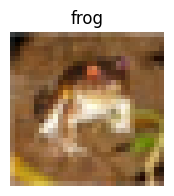

In [29]:
idx_to_plot = 0

plt.figure(figsize=(2, 2))
plt.imshow(x_train[idx_to_plot])
plt.title(cifar10_labels[y_train[idx_to_plot].item()])
plt.axis('off')
plt.show()

Este dataset ha sido muy importante en los desarrollos tempranos del deep learning, dado su tamaño y diversidad, sirviendo de catalizador de nuevos avances. Entre estos se destacan los siguientes:

- Deep Residual Learning for Image Recognition [2]
- Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift [3]
- Dropout: A Simple Way to Prevent Neural Networks from Overfitting [4]

### Capas densas para imagenes

Transformando las imágenes de una matriz a un vector es posible procesarlas a través de redes neuronales compuestas exclusivamente de capas densas

In [30]:
print(f'Tamaño de entrada: {x_train.shape[1] * x_train.shape[2] * x_train.shape[3]}')

Tamaño de entrada: 3072


Primero, como ya habreis visto, es necesario hacer one-hot-encoding de los labels para poder entrenar al modelo:

In [31]:
y_train_cat, y_test_cat = to_categorical(y_train), to_categorical(y_test)

Además, también vamos a necesitar estandarizar, en este caso vamos a hacer una min-max normalization:

In [32]:
x_train, x_test = x_train / 255, x_test / 255 # Normalization of the data (x - xmin)/(xmax - xmin)

Vamos a definir un primer modelo denso con función de activación ReLU

In [33]:
model_dense = keras.Sequential()
model_dense.add(layers.Flatten(input_shape=(x_train.shape[1:]))) 
model_dense.add(layers.Dense(units=128, activation='relu'))
model_dense.add(layers.Dense(units=64, activation='relu')) 
model_dense.add(layers.Dense(units=10, activation='softmax')) 

/Users/claudiavello/.pyenv/versions/machinelearning1/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Y le vamos a entrenar para minimizar la categorical crossentropy con el stochastic gradient descent

In [34]:
model_dense.compile(
  optimizer='SGD',
  loss = "categorical_crossentropy",
  metrics = ["accuracy"]
)

Si hacemos un summary del modelo podemos ver como el número de parámetros es considerable, la mayoría de ellos localizados en la primera capa densa.

In [35]:
model_dense.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 402,250 (1.53 MB)

 Trainable params: 402,250 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

Vamos a entrenar el modelo solo por 20 epochs

In [36]:
history = model_dense.fit(x_train, y_train_cat, epochs=20, batch_size=128,
                          validation_split=0.2)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2219 - loss: 2.1332 - val_accuracy: 0.3004 - val_loss: 1.9440
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3373 - loss: 1.8719 - val_accuracy: 0.3261 - val_loss: 1.8810
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3626 - loss: 1.8132 - val_accuracy: 0.3501 - val_loss: 1.8221
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3817 - loss: 1.7567 - val_accuracy: 0.3591 - val_loss: 1.7881
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3956 - loss: 1.7181 - val_accuracy: 0.3711 - val_loss: 1.7789
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3990 - loss: 1.6892 - val_accuracy: 0.3911 - val_loss: 1.7302
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4216 - loss: 1.6541 - val_accuracy: 0.4050 - val_loss: 1.6942
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4205 - loss: 1.6425 - val_accuracy: 0.

Y calculamos las predicciones en el periodo de test

In [37]:
preds_dense_test = model_dense.predict(x_test)
preds_dense_test_cat = np.argmax(preds_dense_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step


El modelo predice automobile para una imagen con automobile


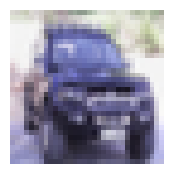

In [38]:
def plot_prediction(idx_to_plot, preds_cat,
                    x_test=x_test, y_test=y_test, cifar10_labels=cifar10_labels):

    print(f'El modelo predice {cifar10_labels[preds_dense_test_cat[idx_to_plot].item()]}'
          f' para una imagen con {cifar10_labels[y_test[idx_to_plot].item()]}')
    
    plt.figure(figsize=(2, 2))
    plt.imshow(x_test[idx_to_plot])
    plt.axis('off')
    plt.show()

plot_prediction(idx_to_plot=9, preds_cat=preds_dense_test_cat)

Para ver como de bien lo hace el modelo, vamos a calcular la accuracy para el periodo de test

In [39]:
overall_accuracy = accuracy_score(y_test, preds_dense_test_cat)
print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')

Overall Accuracy: 44.98%


Podemos ver esta accuracy en detalle para cada una de las distintas clases:

In [40]:
cm = confusion_matrix(y_test, preds_dense_test_cat)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
for idx, acc in enumerate(per_class_accuracy):
    print(f"Accuracy for class {idx} ({cifar10_labels[idx]}): {acc * 100:.2f}%")

Accuracy for class 0 (airplane): 51.90%
Accuracy for class 1 (automobile): 41.20%
Accuracy for class 2 (bird): 23.30%
Accuracy for class 3 (cat): 40.70%
Accuracy for class 4 (deer): 23.70%
Accuracy for class 5 (dog): 31.10%
Accuracy for class 6 (frog): 75.50%
Accuracy for class 7 (horse): 39.70%
Accuracy for class 8 (ship): 65.20%
Accuracy for class 9 (truck): 57.50%


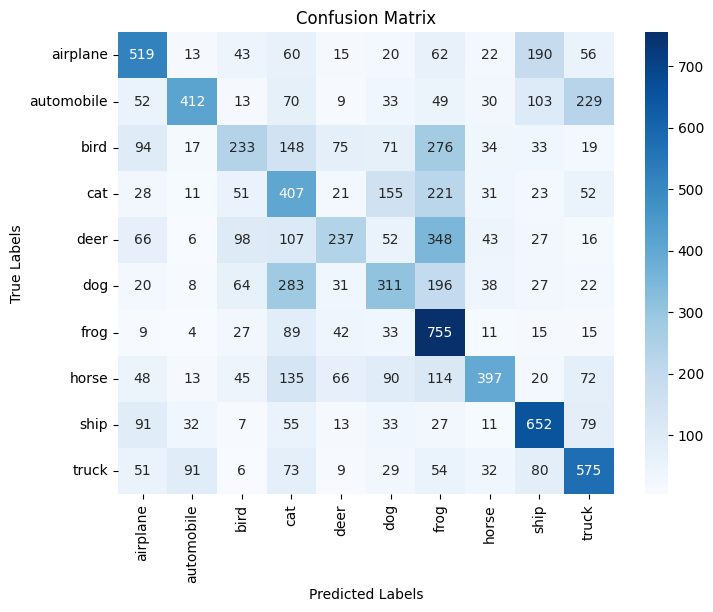

In [41]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=cifar10_labels.values(), yticklabels=cifar10_labels.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Como bien hemos visto, la naturaleza de las capas densas implica, para imágenes, números de parámetros bastante grandes, lo cual puede llevarnos a problemas como el *overfitting*. En el campo de la visión por computador esto puede ser un problema dada la necesidad de trabajar con imágenes mucho más grandes. Para analizar este problema más a fondo, veamos qué ocurre con el número de parámetros asociados a la primera capa densa a medida que aumentamos el tamaño de imagen de entrada del modelo anterior.

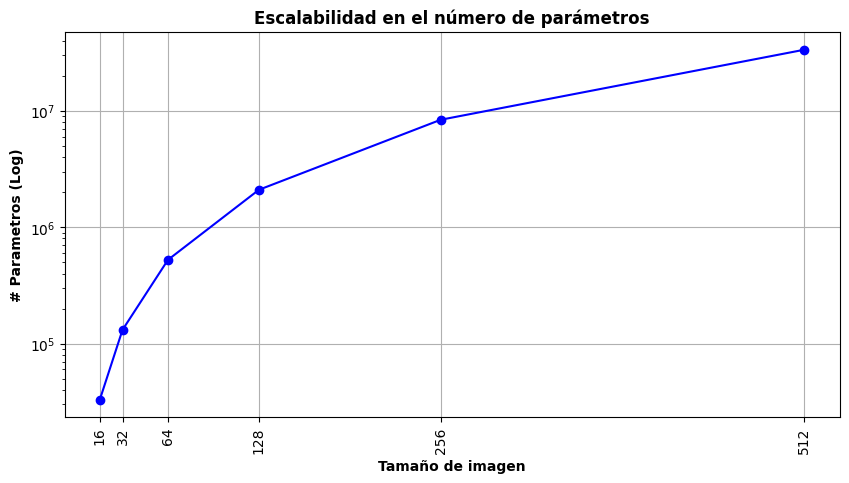

In [42]:
def weight_scalability_dense(hidden_layer_size):
    
    image_sizes = [2**i for i in range(4, 10)]
    
    num_parameters_per_size = []
    for size in image_sizes:
        num_param = (size * size * hidden_layer_size) + hidden_layer_size
        num_parameters_per_size.append(num_param)
    
    plt.figure(figsize=(10, 5))
    plt.plot(image_sizes, num_parameters_per_size, marker='o', linestyle='-',
             color='blue')
    plt.xticks(ticks=image_sizes, labels=image_sizes, rotation=90)
    plt.xlabel('Tamaño de imagen', weight='bold')
    plt.ylabel('# Parametros (Log)', weight='bold')
    plt.yscale('log')
    plt.title('Escalabilidad en el número de parámetros', weight='bold')
    plt.grid()
    plt.show()

weight_scalability_dense(hidden_layer_size=128)

Cómo podemos apreciar el número de parámetros en la primera capa densa se dispara a medida que la imagen que le entra al modelo es mayor. Imaginemos que tenemos una imagen de entrada con dimensiones $N_1 \times N_2$ y queremos añadir $a$ pixeles en las filas y $b$ pixeles en las columnas. La dimensión del vector que le entra a la red es la siguiente:

$(N_1 + a) \times (N_2 + b) = N_1 \cdot N_2 + N_1 \cdot b + N_2 \cdot a + a \cdot b$

Por lo que el número de parámetros a añadir al modelo es $(N_1 \cdot b + N_2 \cdot a + a \cdot b) \times M_1$, siendo $M_1$ el número de neuronas en la primera capa densa. Este es uno de los principales motivos por los que este tipo de capas no están tan extendidas en el campo de la visión por computador (como primeras capas, ya hemos visto que sí que se utilizan al final de las redes convolucionales para hacer la clasificación). Por ejemplo, uno de los modelos más avanzados para la generación de imágenes [5], se entrena con imágenes con un tamaño $> 1024$ pixeles.

### Capas convolucionales

La implementación moderna de capa convolucional se le atribuye a [Yann LeCun](https://www.youtube.com/watch?v=FwFduRA_L6Q) [6], aunque previamente se habian explorado estas ideas en otros contextos [7]. [De forma intuitiva](https://www.youtube.com/watch?v=xjqCTp4xAtA) la salida de la capa convolucional es el resultado de *deslizar* un kernel a través de la imagen de entrada, calculando en cada deslizamiento una suma de la correspondiente parcela de la imagen de entrada ponderada por los pesos del kernel.

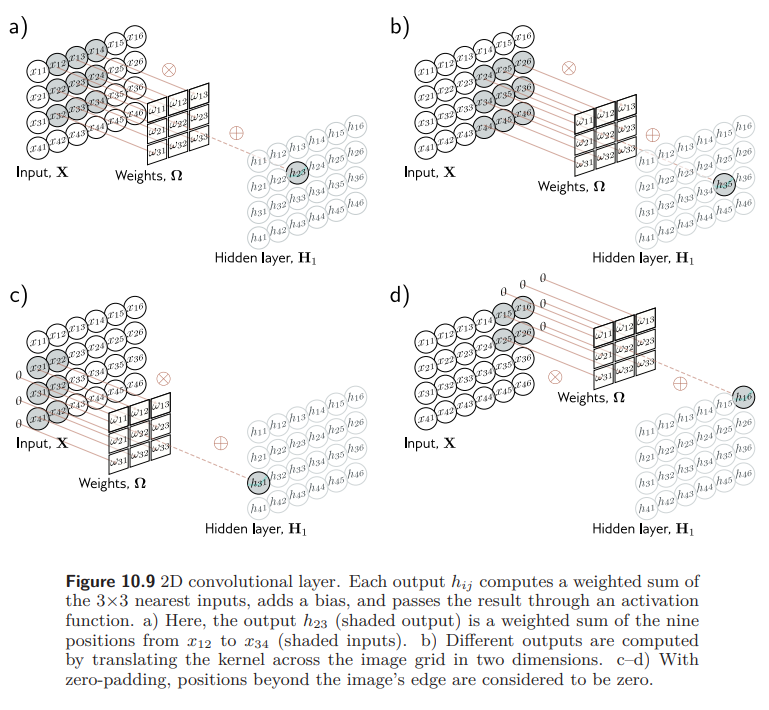

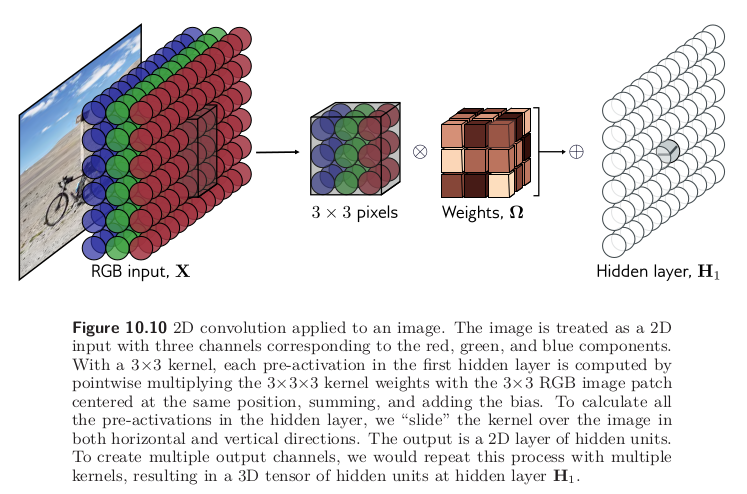

Las convoluciones nos aportan una serie de beneficios muy útiles para el procesamiento de imágenes:

- **Comparten parámetros**: Los parámetros del kernel que deslizamos no cambian, son los mismos a través de toda la imagen. Esto hace a la capa convolucional tener **translation equivariance**, algo idoneo para procesar imágenes.
- **Inductive bias**: Los kernels suelen ser pequeños en comparación con la imagen de entrada, por lo que van a aprender patrones locales. Estamos restringiendo el número de funciones a aprender por el modelo.
- La **superposición** de capas convolucionales permite aprender patrones complejos a partir de patrones más sencillos.

Y una de las cosas más importantes, al no conectar todo con todo y al compartir parámetros el **número de parámetros en comparación con una capa densa se reducen significativamente**.

La convolución en Keras se implementa a través de `layers.Conv2D`. Modifiquemos el modelo anterior añadiendo convoluciones en vez de capas densas.

In [43]:
model_conv = keras.Sequential()
model_conv.add(keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model_conv.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model_conv.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model_conv.add(keras.layers.Flatten()) 
model_conv.add(layers.Dense(units=10, activation='softmax')) 

/Users/claudiavello/.pyenv/versions/machinelearning1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [44]:
model_conv.compile(
  optimizer='SGD',
  loss = "categorical_crossentropy",
  metrics = ["accuracy"]
)

Como podemos ver el número de parámetros se ha reducido de forma significativa. De hecho podemos ver como la mayor parte de parámetros vienen de la última capa densa.

In [45]:
model_conv.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │       216,330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,362 (868.60 KB)

 Trainable params: 222,362 (868.60 KB)

 Non-trainable params: 0 (0.00 B)

A continuación entrenamos y evaluamos este modelo:

In [46]:
history = model_conv.fit(x_train, y_train_cat, epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.1339 - loss: 2.2536 - val_accuracy: 0.3129 - val_loss: 1.9512
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.3207 - loss: 1.9254 - val_accuracy: 0.3763 - val_loss: 1.7801
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.3843 - loss: 1.7584 - val_accuracy: 0.3998 - val_loss: 1.6870
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.4204 - loss: 1.6552 - val_accuracy: 0.4264 - val_loss: 1.6170
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.4365 - loss: 1.5871 - val_accuracy: 0.4330 - val_loss: 1.6232
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.4650 - loss: 1.5184 - val_accuracy: 0.4345 - val_loss: 1.6044
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.4740 - loss: 1.4845 - val_accuracy: 0.4609 - val_loss: 1.5272
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.4944 - loss: 1.4373 - val_accu

Hacemos las predicciones en el periodo de test y hacemos una pequeña evaluación

In [47]:
preds_conv_test = model_conv.predict(x_test)
preds_conv_test_cat = np.argmax(preds_conv_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


El modelo predice truck para una imagen con truck


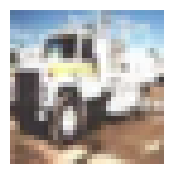

In [48]:
plot_prediction(idx_to_plot=170, preds_cat=preds_conv_test_cat)

In [49]:
overall_accuracy = accuracy_score(y_test, preds_conv_test_cat)
print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')

Overall Accuracy: 54.38%


In [50]:
cm = confusion_matrix(y_test, preds_conv_test_cat)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
for idx, acc in enumerate(per_class_accuracy):
    print(f"Accuracy for class {idx} ({cifar10_labels[idx]}): {acc * 100:.2f}%")

Accuracy for class 0 (airplane): 38.80%
Accuracy for class 1 (automobile): 62.30%
Accuracy for class 2 (bird): 55.70%
Accuracy for class 3 (cat): 45.80%
Accuracy for class 4 (deer): 52.90%
Accuracy for class 5 (dog): 41.80%
Accuracy for class 6 (frog): 54.70%
Accuracy for class 7 (horse): 54.10%
Accuracy for class 8 (ship): 75.20%
Accuracy for class 9 (truck): 62.50%


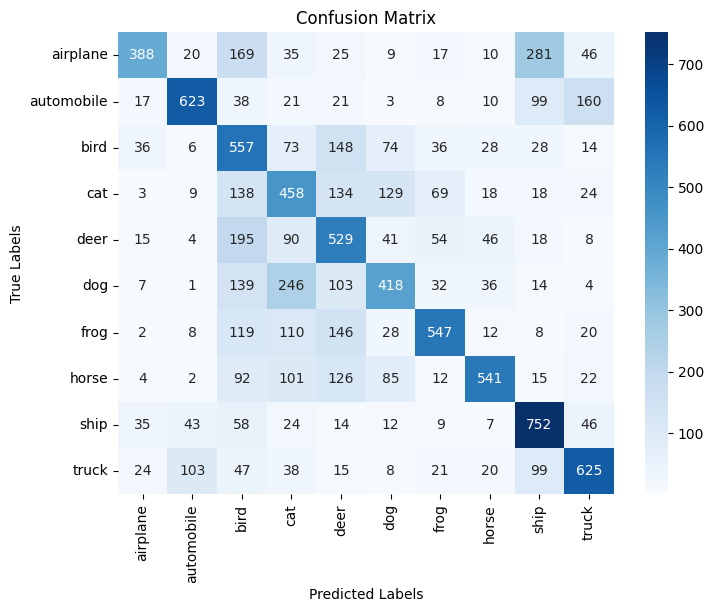

In [51]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=cifar10_labels.values(), yticklabels=cifar10_labels.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

En este caso, el número de parámetros de la primera capa convolucional del modelo se va a mantener constante con el tamaño de la imagen de entrada.

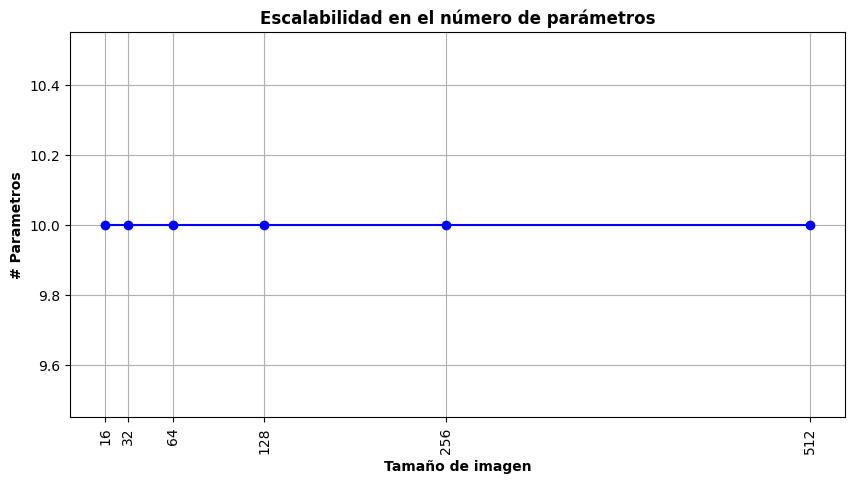

In [52]:
def weight_scalability_conv(kernel_size):
    
    image_sizes = [2**i for i in range(4, 10)]
    
    num_parameters_per_size = []
    for size in image_sizes:
        num_param = (kernel_size * kernel_size) + 1
        num_parameters_per_size.append(num_param)
    
    plt.figure(figsize=(10, 5))
    plt.plot(image_sizes, num_parameters_per_size, marker='o', linestyle='-',
             color='blue')
    plt.xticks(ticks=image_sizes, labels=image_sizes, rotation=90)
    plt.xlabel('Tamaño de imagen', weight='bold')
    plt.ylabel('# Parametros', weight='bold')
    plt.title('Escalabilidad en el número de parámetros', weight='bold')
    plt.grid()
    plt.show()

weight_scalability_conv(kernel_size=3)

Hasta ahora solo hemos visto cómo implementar la capa convolucional, pero cómo ya habreis visto existen otros elementos que se suelen utilizar en conjunción con esta capa convolucional. Estas técnicas también se pueden implementar con Keras:

- **Padding**: Se puede añadir o bien a través de `layers.ZeroPadding2D` o con el argumento `padding` en `layer.Conv2D`. Con esto rodeamos la imagen de entrada a una capa convolucional con ceros. Esto es útil para evitar la infrarepresentación de los bordes de la imagen.
- **Strided convolution**: Esto se controla a través del argumento `strides` y determina el número de pixeles sobre el que nos movemos al hacer un desplazamiento del kernel sobre la imagen de entrada. A mayor stride menos la dimensión de las activaciones de salida de la capa convolucional (hacemos menos deslizamientos del kernel).
- **Pooling**: Se implementa a través de `layers.MaxPooling2D` y consiste en reducir la dimensión de la imagen tomando el máximo alrededor de ventanas de un tamaño determinado (e.g., 2x2). Con esto buscamos reducir la imagen a la vez que hacemos hincapié en la translation equivariance.

Podeis encontrar más técnicas así como mas detalles sobre estos en la correspondiente [documentación de Keras](https://keras.io/api/).

Con todos estos elementos podemos construir una red convolucional más compleja con muchos más elementos. Por ejemplo:

In [53]:
model_conv_2 = keras.models.Sequential()

model_conv_2.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_conv_2.add(layers.MaxPooling2D((2, 2)))
model_conv_2.add(layers.Dropout(0.25))

model_conv_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_conv_2.add(layers.MaxPooling2D((2, 2)))
model_conv_2.add(layers.Dropout(0.25))

model_conv_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_conv_2.add(layers.MaxPooling2D((2, 2)))
model_conv_2.add(layers.Dropout(0.25))

model_conv_2.add(layers.Flatten())
model_conv_2.add(layers.Dense(64, activation='relu'))
model_conv_2.add(layers.Dropout(0.5))
model_conv_2.add(layers.Dense(10, activation='softmax'))

/Users/claudiavello/.pyenv/versions/machinelearning1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [54]:
model_conv_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,682 (158.91 KB)

 Trainable params: 40,682 (158.91 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
model_conv_2.compile(
  optimizer='SGD',
  loss = "categorical_crossentropy",
  metrics = ["accuracy"]
)

In [56]:
history = model_conv_2.fit(x_train, y_train_cat, epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.1065 - loss: 2.3146 - val_accuracy: 0.1191 - val_loss: 2.2971
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.1238 - loss: 2.2901 - val_accuracy: 0.1931 - val_loss: 2.2798
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.1513 - loss: 2.2606 - val_accuracy: 0.2238 - val_loss: 2.2135
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.1729 - loss: 2.1907 - val_accuracy: 0.2273 - val_loss: 2.1292
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.1878 - loss: 2.1415 - val_accuracy: 0.2060 - val_loss: 2.1397
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.2005 - loss: 2.1046 - val_accuracy: 0.2433 - val_loss: 2.0801
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.2045 - loss: 2.0878 - val_accuracy: 0.2329 - val_loss: 2.0797
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.2168 - loss: 2.0700 - val_accu

In [57]:
preds_conv_2_test = model_conv_2.predict(x_test)
preds_conv_2_test_cat = np.argmax(preds_conv_2_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [58]:
overall_accuracy = accuracy_score(y_test, preds_conv_2_test_cat)
print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')

Overall Accuracy: 36.80%


In [59]:
cm = confusion_matrix(y_test, preds_conv_2_test_cat)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
for idx, acc in enumerate(per_class_accuracy):
    print(f"Accuracy for class {idx} ({cifar10_labels[idx]}): {acc * 100:.2f}%")

Accuracy for class 0 (airplane): 44.70%
Accuracy for class 1 (automobile): 78.50%
Accuracy for class 2 (bird): 2.30%
Accuracy for class 3 (cat): 10.70%
Accuracy for class 4 (deer): 32.70%
Accuracy for class 5 (dog): 28.30%
Accuracy for class 6 (frog): 60.00%
Accuracy for class 7 (horse): 41.10%
Accuracy for class 8 (ship): 31.70%
Accuracy for class 9 (truck): 38.00%


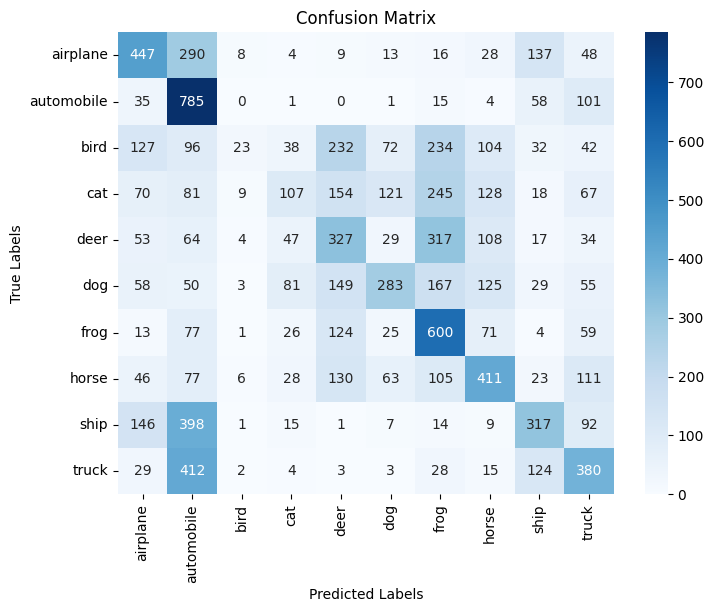

In [60]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=cifar10_labels.values(), yticklabels=cifar10_labels.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Redes residuales

La evidencia obtenida de los desarrollos tempranos del deep learning sugería que a medida que los modelos se hacían más *deep* se obtenian mejores resultados, sin embargo a partir de cierta *deepness* los modelos no devolvían los resultados que se esperaba.

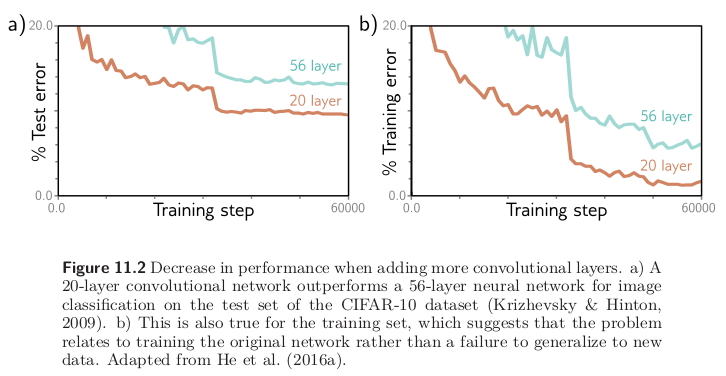

El principal motivo detrás de este fenómeno son los *shattered gradients*. Si tenemos un modelo con muchas capas, pequeños cambios en los parámetros de las primeras capas van a provocar respuestas muy distintas en la salida, ya que se van a aplicar muchas transformaciones, unas sobre otras. Esto se va a reflejar en un gradiente muy ruidoso:

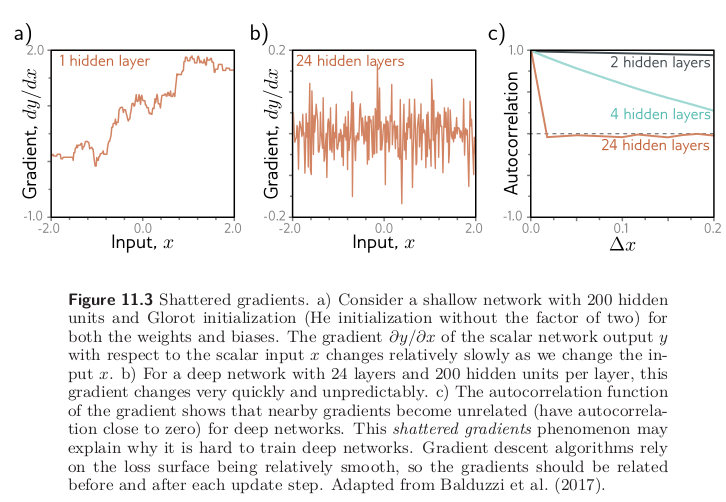

Lo cual va a dificultar el entrenamiento del modelo, ya que tendremos que buscar el mínimo en una superficie de este estilo:

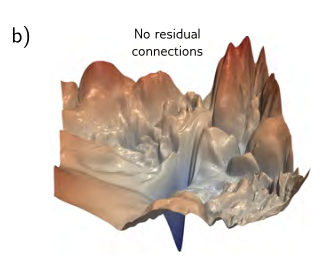

Para evitar este fenómeno y poder entrenar modelos muy *deep* se recurren a las capas residuales. En los modelos formados por este tipo de capas, en vez de procesar como entrada la salida de la capa anterior, se procesa la salida de la capa anterior y el resultado se le suma/concatena a esta, es decir: 

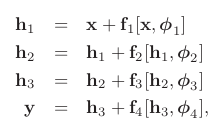

siendo $f_i$ las distintas capas residuales (parametrizadas por $\phi_i$) y $h_i$ las representaciones aprendidas por cada una de estas. Esta modificación evita que el gradiente sea tan ruidoso, ayudando a que el *gradient descent* se mueva hacia el mínimo sobre una superficie mucho más suave:

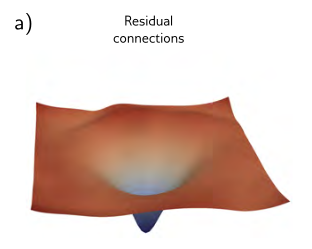

De forma resumida, una red estándar (sin conexiones residuales) se organiza así:

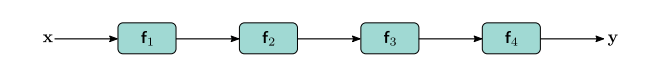

Mientras que una red residual se configura de la siguiente manera:

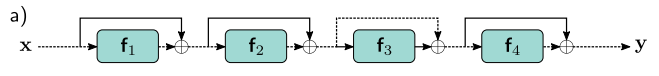

Para visualizar estos modelos vamos a volver a cargar el dataset de CIFAR10

In [61]:
cifar10_labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

num_classes = 10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train, x_test = x_train / 255, x_test / 255
y_train_cat, y_test_cat = to_categorical(y_train), to_categorical(y_test)

Ahora vamos a implementar un modelo residual. Para ello vamos a recurrir al modelo funcional de Keras. Comenzaremos definiendo la siguiente capa residual:

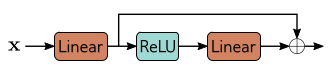

In [62]:
def residual_block(x, filters, kernel_size):

    shortcut = x

    x = layers.Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(x)

    x = layers.Add()([x, shortcut])

    return x

Y ahora procedemos a construir el modelo en base a esta capa residual:

In [63]:
inputs = layers.Input(shape=x_train.shape[1:])

x = layers.Conv2D(filters=32, kernel_size=3)(inputs)
x = layers.Activation('relu')(x)

x = residual_block(x, filters=32, kernel_size=3)
x = residual_block(x, filters=32, kernel_size=3)
x = residual_block(x, filters=32, kernel_size=3)
x = residual_block(x, filters=32, kernel_size=3)

x = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_residual = keras.models.Model(inputs=inputs, outputs=outputs)

In [64]:
model_residual.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 30, 30,    │        896 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 30, 30,    │          0 │ conv2d_6[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 30, 30,    │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 30, 30,    │          0 │ conv2d_7[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 30, 30,    │      9,248 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 30,    │          0 │ conv2d_8[0][0],   │
│                     │ 32)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 30, 30,    │      9,248 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 30, 30,    │          0 │ conv2d_9[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 30, 30,    │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 30,    │          0 │ conv2d_10[0][0],  │
│                     │ 32)               │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 30, 30,    │      9,248 │ add_1[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 30, 30,    │          0 │ conv2d_11[0][0]   │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 30, 30,    │      9,248 │ activation_3[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 30, 30,    │          0 │ conv2d_12[0][0],  │
│                     │ 32)               │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 30, 30,    │      9,248 │ add_2[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 30, 30,    │          0 │ conv2d_13[0][0] 

 Total params: 362,890 (1.38 MB)

 Trainable params: 362,890 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

Le entrenamos y evaluamos, como hemos estado haciendo hasta ahora

In [65]:
model_residual.compile(
  optimizer='SGD',
  loss = "categorical_crossentropy",
  metrics = ["accuracy"]
)

history = model_residual.fit(x_train, y_train_cat,
                             epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 253ms/step - accuracy: 0.2808 - loss: 2.0280 - val_accuracy: 0.3967 - val_loss: 1.6906
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 87s 277ms/step - accuracy: 0.4520 - loss: 1.5517 - val_accuracy: 0.4664 - val_loss: 1.4993
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 80s 255ms/step - accuracy: 0.5002 - loss: 1.4099 - val_accuracy: 0.5003 - val_loss: 1.3867
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 264ms/step - accuracy: 0.5402 - loss: 1.3007 - val_accuracy: 0.5457 - val_loss: 1.2704
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 269ms/step - accuracy: 0.5763 - loss: 1.1965 - val_accuracy: 0.5241 - val_loss: 1.3214
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 266ms/step - accuracy: 0.6122 - loss: 1.1134 - val_accuracy: 0.5686 - val_loss: 1.2191
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 268ms/step - accuracy: 0.6340 - loss: 1.0417 - val_accuracy: 0.5834 - val_loss: 1.1775
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 258ms/step - accuracy: 0.6555 - loss: 0

In [66]:
preds_residual_test = model_residual.predict(x_test)
preds_residual_test_cat = np.argmax(preds_residual_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


In [67]:
overall_accuracy = accuracy_score(y_test, preds_residual_test_cat)
print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')

Overall Accuracy: 61.58%


Las conexiones residuales son parte de muchas arquitecturas ampliamente utilizadas hoy día, por ejemplo la ResNet [10], o la U-Net [11]. Esta última se puede ver aplicada en multitud de campos. Por ejemplo, en la generación de imágenes juega un papel fundamental [5]. Su arquitectura tiene la siguiente forma:

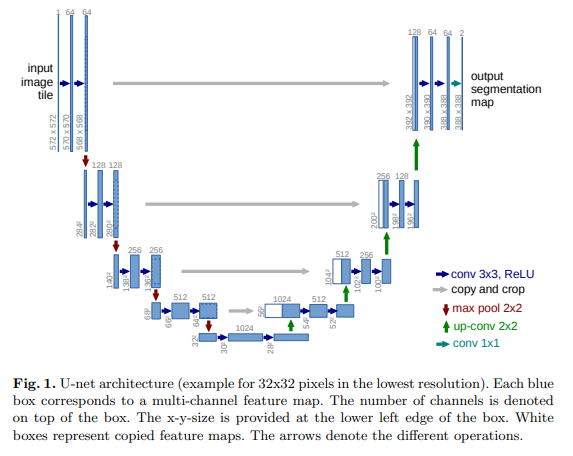

La U-Net está formada por un encoder y un decoder. El encoder reduce la dimensión espacial de los datos de entrada hasta un espacio latente que codifica la información espacial de los datos. El decoder recupera el tamaño de la imagen original a través de operaciones opuestas a la convolución, por ejemplo con una interpolación bilineal o nearest. Para esta reconstrucción (decoder) el modelo necesita tener en cuenta aspectos de los datos de entrada. Para facilitar esto, se introducen conexiones entre el encoder y el decoder (vease la figura). En este caso las capas residuales concatenan los datos de entrada y su version procesada, en vez de sumarlos.



A continuación se muestra una implementación en Keras de una U-Net sencilla

In [68]:
def conv_block(x, filters, kernel_size):
    """
    Bloque convolucional sin reducción de dimensionalidad espacial
    """
    x = layers.Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = layers.Activation('relu')(x)
    return x

def encoder_block(x, filters, kernel_size):
    """
    Bloque convolucional del encoder con reducción de la dimensionalidad
    espacial a través de max-pooling
    """
    x = layers.Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = layers.Activation('relu')(x) # Esto lo guardamos para concatenarlo al decoder
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(x, concat_data, filters, kernel_size):
    """
    Bloque convolucional del decoder aumentando la dimensionalidad
    espacial a través de upsampling
    """
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Concatenate()([x, concat_data]) # Concatenamos los datos del encoder y decoder
    x = layers.Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = layers.Activation('relu')(x) 
    return x

In [69]:
inputs = layers.Input(shape=x_train.shape[1:])

# Encoder
x1, p1 = encoder_block(inputs, filters=8, kernel_size=3)
x2, p2 = encoder_block(p1, filters=16, kernel_size=3)
x3, p3 = encoder_block(p2, filters=32, kernel_size=3)

# Conv
x4 = conv_block(p3, filters=64, kernel_size=3)

# Decoder
d3 = decoder_block(x4, x3, filters=32, kernel_size=3) 
d2 = decoder_block(d3, x2, filters=16, kernel_size=3) 
d1 = decoder_block(d2, x1, filters=8, kernel_size=3) 

# Final 1x1 conv
outputs = layers.Conv2D(filters=3, kernel_size=1)(d1)

model_unet = keras.models.Model(inputs=inputs, outputs=outputs)

In [70]:
model_unet.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 32, 32, 8) │        224 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 32, 32, 8) │          0 │ conv2d_15[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16, 8) │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 16, 16,    │      1,168 │ max_pooling2d_3[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 16, 16,    │          0 │ conv2d_16[0][0]   │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 8, 8, 16)  │          0 │ activation_6[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 8, 8, 32)  │      4,640 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 8, 8, 32)  │          0 │ conv2d_17[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 4, 4, 32)  │          0 │ activation_7[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 4, 4, 64)  │     18,496 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 4, 4, 64)  │          0 │ conv2d_18[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 8, 8, 64)  │          0 │ activation_8[0][… │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8, 96)  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │                   │            │ activation_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 8, 8, 32)  │     27,680 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 8, 8, 32)  │          0 │ conv2d_19[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 16, 16,    │          0 │ activation_9[0][… │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 48)               │            │ activation_6[0][

 Total params: 60,899 (237.89 KB)

 Trainable params: 60,899 (237.89 KB)

 Non-trainable params: 0 (0.00 B)

Vamos a entrenar este modelo para eliminar ruido de unas imágenes. Para ello, partiendo de CIFAR10, vamos a añadir de forma sintetica ruido blanco con media 0 y desviación típica de 1: 

In [71]:
noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

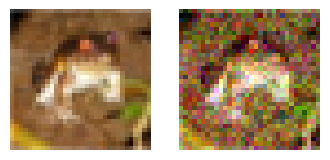

In [72]:
def plot_standard_and_noisy(image, image_noisy):
    
    plt.figure(figsize=(4, 2))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(image_noisy)
    plt.axis("off")

    plt.show()

idx_to_plot = 0
plot_standard_and_noisy(image=x_train[idx_to_plot, :],
                        image_noisy=x_train_noisy[idx_to_plot, :])

El objetivo, por lo tanto, es dada una imagen de entrada con ruido eliminar este ruido y obtener como salida la imagen sin el ruido. Por ello para este modelo nuestros inputs seran las imagenes con ruido y nuestro output las imagenes sin él. Para lograr esto vamos a entrenar el modelo con el **Mean Squared Error (MSE)** como función de pérdida. 

In [73]:
model_unet.compile(
  optimizer='SGD',
  loss = "mse",
  metrics = ["mae"]
)

history = model_unet.fit(x_train_noisy, x_train,
                         epochs=100, batch_size=128, validation_split=0.2)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - loss: 0.1368 - mae: 0.2855 - val_loss: 0.0282 - val_mae: 0.1315
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - loss: 0.0257 - mae: 0.1249 - val_loss: 0.0200 - val_mae: 0.1080
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - loss: 0.0190 - mae: 0.1048 - val_loss: 0.0163 - val_mae: 0.0956
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - loss: 0.0158 - mae: 0.0941 - val_loss: 0.0142 - val_mae: 0.0885
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - loss: 0.0138 - mae: 0.0875 - val_loss: 0.0128 - val_mae: 0.0840
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - loss: 0.0126 - mae: 0.0833 - val_loss: 0.0118 - val_mae: 0.0807
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - loss: 0.0117 - mae: 0.0803 - val_loss: 0.0110 - val_mae: 0.0781
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - loss: 0.0109 - mae: 0.0777 - val_loss: 0.0104 - val_mae: 0.0759
Epoch 9/100
313/313 ━━━━━━━━━━━━

Ahora calculamos las predicciones y comparamos con las imágenes sin ruido

In [74]:
preds_unet_test = model_unet.predict(x_test_noisy)
preds_unet_test = np.clip(preds_unet_test, 0., 1.)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


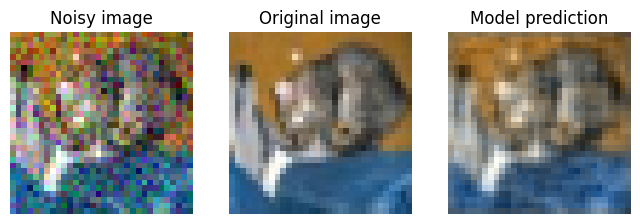

In [75]:
def plot_prediction_unet(image_test, image_test_noisy, pred_model):
    
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image_test_noisy)
    plt.title('Noisy image')
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(image_test)
    plt.title('Original image')
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_model)
    plt.title('Model prediction')
    plt.axis("off")
    
    plt.show()

idx_to_plot = 0
plot_prediction_unet(image_test=x_test[idx_to_plot, :],
                     image_test_noisy=x_test_noisy[idx_to_plot, :],
                     pred_model=preds_unet_test[idx_to_plot, :])

## Referencias

**[1]** Krizhevsky, A., & Hinton, G. (2009). *Learning multiple layers of features from tiny images.*

**[2]** He, K., Zhang, X., Ren, S., & Sun, J. (2016). *Deep residual learning for image recognition.* In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

**[3]** Ioffe, S. (2015). *Batch normalization: Accelerating deep network training by reducing internal covariate shift*. arXiv preprint arXiv:1502.03167.

**[4]** Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). *Dropout: a simple way to prevent neural networks from overfitting*. The journal of machine learning research, 15(1), 1929-1958.

**[5]** Rombach, R., Blattmann, A., Lorenz, D., Esser, P., & Ommer, B. (2022). *High-resolution image synthesis with latent diffusion models*. In Proceedings of the IEEE/CVF conference on computer vision and pattern recognition (pp. 10684-10695).

**[6]** LeCun, Y., & Bengio, Y. (1995). *Convolutional networks for images, speech, and time series*. The handbook of brain theory and neural networks, 3361(10), 1995.

**[7]** Fukushima, K., Miyake, S., & Ito, T. (1983). *Neocognitron: A neural network model for a mechanism of visual pattern recognition*. IEEE transactions on systems, man, and cybernetics, (5), 826-834.

**[8]** Prince, S. J. (2023). *Understanding deep learning*. MIT press.

**[9]** LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). *Gradient-based learning applied to document recognition*. Proceedings of the IEEE, 86(11), 2278-2324.

**[10]** He, K., Zhang, X., Ren, S., & Sun, J. (2016). *Deep residual learning for image recognition*. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

**[11]** Ronneberger, O., Fischer, P., & Brox, T. (2015). *U-net: Convolutional networks for biomedical image segmentation*. In Medical image computing and computer-assisted intervention–MICCAI 2015: 18th international conference, Munich, Germany, October 5-9, 2015, proceedings, part III 18 (pp. 234-241). Springer International Publishing.